# Imports and requirements

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import pandas as pd
import sys
import pickle
import tqdm
import numpy as np
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

from scipy.stats import gmean, hmean
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import warnings
warnings.filterwarnings("ignore")



# !!! измените "2" на номер доступной вам сuda
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#pd.set_option("display.max_columns", None)

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append("../")


In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 1171
seed_everything(SEED)

### Загрузка и предварительная обработка данных

In [4]:
TRAIN_DATA_PATH = "G:\\Alfa_Bank_competition\\data_original\\train_data"
TEST_DATA_PATH = "G:\\Alfa_Bank_competition\\data_original\\test_data"

TRAIN_TARGET_PATH = "G:\\Alfa_Bank_competition\\data_original\\train_target.csv"

In [5]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [6]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils_with_mask import features, transform_credits_to_sequences, create_padded_buckets

В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [7]:
%%time
from collections import defaultdict

train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 2),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        #credits_frame.drop(columns=["id"], inplace=True)

        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        #credits_frame.drop(columns=["id"], inplace=True)

        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\test_data\test_data_0.pq
G:\Alfa_Bank_competition\data_original\test_data\test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 30.8 s


Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [8]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

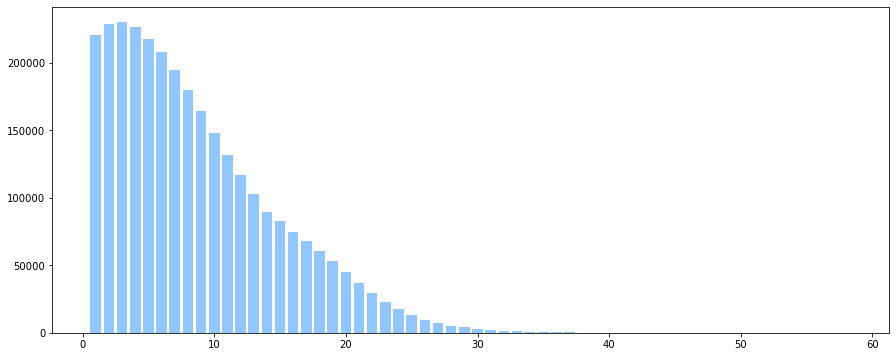

In [9]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

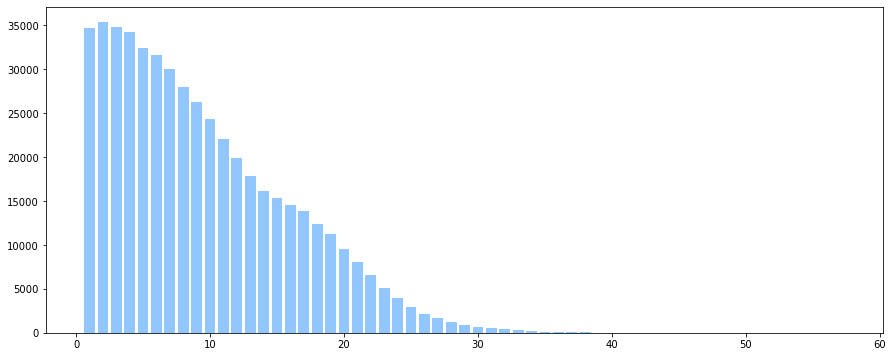

In [10]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [11]:
train_lens.max(), test_lens.max()

(58, 57)

Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [12]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

Также рассмотрим уникальные значения признаков

In [13]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

Вся предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [14]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False, shuffle_rn: bool = False, num_last_credits: int = 0):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame, num_last_credits=num_last_credits, shuffle_rn=shuffle_rn)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

### K-FOLDS

Разобьем данные на 5 фолдов для обучения моделей и получения Out Of Bag прогнозов. Для нейросетевых методов будем использовать два вариента разбиения на фолды. В первом варианте порядок строк (исторических данных по кредитам клиента) остается неизменным. Во втором случае происходит случайное перемешивание строк.

**Первый вариант разбиения:**

In [17]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [18]:
cv.split(train_target, train_target['flag'])

<generator object _BaseKFold.split at 0x000001AAEF0C4C80>

In [19]:
for fold_, (train_idx, val_idx) in enumerate(cv.split(train_target, train_target['flag']), 1):
    if fold_ == 5:
        print(fold_)
        !mkdir G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn
        !mkdir G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn

        TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
        VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"

        train = train_target.iloc[train_idx]
        val = train_target.iloc[val_idx]


        create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=TRAIN_BUCKETS_PATH,
                                frame_with_ids=train,
                                num_parts_to_preprocess_at_once=2, 
                                num_parts_total=12, has_target=True)

        create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=VAL_BUCKETS_PATH,
                                frame_with_ids=val,
                                num_parts_to_preprocess_at_once=2, 
                                num_parts_total=12, has_target=True)  

5


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

### K-FOLDS - 2

**Второй вариант разбиения**

In [18]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=715, shuffle=True)

In [19]:
cv.split(train_target, train_target['flag'])

<generator object _BaseKFold.split at 0x000001D0003F55F0>

In [22]:
for fold_, (train_idx, val_idx) in enumerate(cv.split(train_target, train_target['flag']), 1):
    print(fold_)
    !mkdir H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\train_buckets_rnn
    !mkdir H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\val_buckets_rnn

    TRAIN_BUCKETS_PATH = f"H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\val_buckets_rnn"

    train = train_target.iloc[train_idx]
    val = train_target.iloc[val_idx]


    create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=TRAIN_BUCKETS_PATH,
                                frame_with_ids=train,
                                num_parts_to_preprocess_at_once=2, 
                                num_parts_total=12, has_target=True, shuffle_rn=True)

    create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=VAL_BUCKETS_PATH,
                                frame_with_ids=val,
                                num_parts_to_preprocess_at_once=2, 
                                num_parts_total=12, has_target=True, shuffle_rn=True)  

1


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

2


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

3


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

4


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

5


Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_0.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_2.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_4.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_6.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_8.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
G:\Alfa_Bank_competition\data_original\train_data\train_data_10.pq
G:\Alfa_Bank_competition\data_original\train_data\train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

### Тестовая выборка:

In [15]:
TEST_BUCKETS_PATH = "G:\\Alfa_Bank_competition\\test_buckets_rnn"

In [16]:
%%time
тестовая выборка
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Wall time: 0 ns


['G:\\Alfa_Bank_competition\\test_buckets_rnn\\processed_chunk_000.pkl']

### Обучение нейросетевых моделей

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Для создания модели будем использовать фреймворк `torch`. 

Для того, чтобы можно было обучать нейронную сеть и отслеживать ее качество, предоставлены следующие функции:
    `data_generators_with_mask.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для  `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
 - функция `train_models.train_epoch` &ndash; обучает модель одну эпоху.
 - функция `train_models.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
 - функция `ptrain_models.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
 - класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [18]:
from data_generators_with_mask import batches_generator
from train_models import train, train_epoch, eval_model, inference
from training_aux import EarlyStopping

Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [19]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [20]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

**BIDIRECTIONAL RNN + LAST Hidden**

In [21]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_LAST_HIDDEN_FOLDS"

In [22]:
from models import CreditsRNN_LAST_HIDDEN

In [44]:
loss_function = sigmoid_focal_loss
alpha = 0.9

num_epochs = 5
train_batch_size = 64
val_batch_size = 64
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"
    
    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
    
    best_model_name = f"best_checkpoint_rnn_LAST_HIDDEN_fold_{fold_}.pt"

    model_RNN_LAST_HIDDEN = CreditsRNN_LAST_HIDDEN(features, 
                                               embedding_projections, 
                                               rnn_units=128, 
                                               top_classifier_units=32, 
                                               dropout=0, 
                                               spatial_dropout=0).to(device)
    
    optimizer = torch.optim.AdamW(lr=5e-4, params=model_RNN_LAST_HIDDEN.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=1/np.sqrt(10),
            patience=1,
            verbose=True, threshold=0.01,
            threshold_mode='abs', cooldown=0,
            min_lr=1e-6, eps=1e-08)

    train(model_RNN_LAST_HIDDEN, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
          path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
          shuffle=True, print_loss_every_n_batches=500, device=device, lenght=True)


Training fold 1:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.773711).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7770036490243711, val ROC AUC: 0.7737108338943375
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773711 --> 0.780416).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7860739515441013, val ROC AUC: 0.7804156591989901
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.776783. Current best: 0.780416
EarlyStopping counter: 1 out of 3
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7842383174311967, val ROC AUC: 0.776783199093555
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779983. Current best: 0.780416
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.8001122132571945, val ROC AUC: 0.7799831127776533
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779353. Current best: 0.780416
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 2:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.773056).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7757133823329072, val ROC AUC: 0.7730557238091074
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773056 --> 0.778673).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7840023528009195, val ROC AUC: 0.77867254949599
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.775384. Current best: 0.778673
EarlyStopping counter: 1 out of 3
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.784784037026769, val ROC AUC: 0.775384378348853
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.778673 --> 0.779463).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.8021661875012662, val ROC AUC: 0.7794633904200502
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.779463 --> 0.780918).  Saving model...
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8096950465625067, val ROC AUC: 0.78091835514003
Training fold 3:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.769151).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7765645706018005, val ROC AUC: 0.7691507376669753
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.769151 --> 0.772390).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7833744014613515, val ROC AUC: 0.7723904640610401
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.772390 --> 0.773862).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7889804776563297, val ROC AUC: 0.7738616665369613
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773862 --> 0.776063).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.8011950161996071, val ROC AUC: 0.7760625812304207
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.775405. Current best: 0.776063
EarlyStopping counter: 1 out of 3
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8063034575981931, val ROC AUC: 0.7754054613431123
Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.770635).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7768961248077156, val ROC AUC: 0.7706354720171745
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770635 --> 0.775791).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7858087533499766, val ROC AUC: 0.7757907111728621
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774816. Current best: 0.775791
EarlyStopping counter: 1 out of 3
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7869408241250896, val ROC AUC: 0.7748161399423831
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.775791 --> 0.779045).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.8020288882470499, val ROC AUC: 0.7790451910546548
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777173. Current best: 0.779045
EarlyStopping counter: 1 out of 3
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8081114452754024, val ROC AUC: 0.7771734777479598
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.772522).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7770552906313137, val ROC AUC: 0.7725222380278798
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.772522 --> 0.777088).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7854092778408805, val ROC AUC: 0.7770882929430654
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.776888. Current best: 0.777088
EarlyStopping counter: 1 out of 3
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7874179667112435, val ROC AUC: 0.7768878253926795
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777088 --> 0.780638).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.8018348266048133, val ROC AUC: 0.7806383196390706
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.780638 --> 0.781359).  Saving model...
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8095920036894951, val ROC AUC: 0.7813588927634885


Предсказания для тестовых данных:

In [23]:
model_RNN_LAST_HIDDEN = CreditsRNN_LAST_HIDDEN(features, 
                                               embedding_projections, 
                                               rnn_units=128, 
                                               top_classifier_units=32, 
                                               dropout=0, 
                                               spatial_dropout=0).to(device)

model_RNN_LAST_HIDDEN.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_fold_1.pt')))

test_preds_RNN_LAST_HIDDEN = inference(model_RNN_LAST_HIDDEN, dataset_test, batch_size=512, device=device, lenght=True)

test_preds_RNN_LAST_HIDDEN_TOTAL = test_preds_RNN_LAST_HIDDEN.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_RNN_LAST_HIDDEN.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_fold_{fold_}.pt')))

    test_preds_RNN_LAST_HIDDEN = inference(model_RNN_LAST_HIDDEN, dataset_test, batch_size=512, device=device, lenght=True)
    
    
    test_preds_RNN_LAST_HIDDEN_TOTAL = test_preds_RNN_LAST_HIDDEN_TOTAL.merge(test_preds_RNN_LAST_HIDDEN, on='id')\
                                                                       .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [24]:
test_preds_RNN_LAST_HIDDEN_TOTAL['score'] = (test_preds_RNN_LAST_HIDDEN_TOTAL['score_fold_1']\
                                          + test_preds_RNN_LAST_HIDDEN_TOTAL['score_fold_2']\
                                          + test_preds_RNN_LAST_HIDDEN_TOTAL['score_fold_3']\
                                          + test_preds_RNN_LAST_HIDDEN_TOTAL['score_fold_4']\
                                          + test_preds_RNN_LAST_HIDDEN_TOTAL['score_fold_5']) / 5


test_preds_RNN_LAST_HIDDEN_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,0.002171,7.252386e-12,0.000021,6.111582e-09,1.221641e-16,0.000438
1,3000786,0.002288,3.075226e-12,0.000112,2.206464e-08,2.846257e-16,0.000480
2,3019111,0.037445,1.411738e-04,0.025352,2.313488e-03,1.011724e-02,0.015074
3,3345810,0.154487,1.758348e-07,0.015331,1.157137e-04,1.018275e-05,0.033989
4,3434512,0.144362,2.115846e-11,0.002245,7.086300e-05,9.491834e-06,0.029337
...,...,...,...,...,...,...,...
499995,3464951,0.417768,4.333285e-01,0.447533,4.291284e-01,4.227760e-01,0.430107
499996,3028533,0.353061,3.774460e-01,0.390526,3.735240e-01,3.987354e-01,0.378658
499997,3464956,0.423485,4.115852e-01,0.406487,3.954434e-01,4.739827e-01,0.422197
499998,3366101,0.345639,3.429430e-01,0.333768,3.110878e-01,3.826981e-01,0.343227


In [25]:
test_preds_RNN_LAST_HIDDEN_TOTAL[['id', 'score']].to_csv("submission_RNN_LAST_HIDDEN_TOTAL_5_folds.csv", index=None)

**Biderectional RNN SIMPLE**

In [26]:
from models import CreditsRNN_SIMPLE

In [27]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_SIMPLE_BIDIRECTIONAL_FOLDS"

In [64]:
loss_function = sigmoid_focal_loss
alpha = 0.9

num_epochs = 7
train_batch_size = 512
val_batch_size = 512
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"
    
    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
    
    best_model_name = f"best_checkpoint_rnn_BODORECTIONAL_RNN_SIMPLE_fold_{fold_}.pt"

    model_RNN_SIMPLE = CreditsRNN_SIMPLE(features, 
                                         embedding_projections, 
                                         dropout=0, 
                                         spatial_dropout=0).to(device)
    
    optimizer = torch.optim.AdamW(lr=1e-3, params=model_RNN_SIMPLE.parameters())
    
    loss_function = sigmoid_focal_loss
    alpha = 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=1/np.sqrt(10),
            patience=1,
            verbose=True, threshold=0.01,
            threshold_mode='abs', cooldown=0,
            min_lr=1e-6, eps=1e-08)

    train(model_RNN_SIMPLE, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
          path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
          shuffle=True, print_loss_every_n_batches=500, device=device)

Training fold 1:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.770267).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7717284759831806, val ROC AUC: 0.7702670370594229
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770267 --> 0.775942).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7790953453640976, val ROC AUC: 0.7759420139667647
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774199. Current best: 0.775942
EarlyStopping counter: 1 out of 3
Epoch 00003: reducing learning rate of group 0 to 3.1623e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7790951599400034, val ROC AUC: 0.7741991496446886
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.775942 --> 0.781223).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7953471540125632, val ROC AUC: 0.7812230367518214
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779660. Current best: 0.781223
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8002372343204975, val ROC AUC: 0.7796595540024377
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.780969. Current best: 0.781223
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8056684684882995, val ROC AUC: 0.7809686892775154
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779333. Current best: 0.781223
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 2:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.772769).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7736315205268242, val ROC AUC: 0.7727685321833329
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.772769 --> 0.776876).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7797985840121041, val ROC AUC: 0.7768755160970432
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776876 --> 0.778709).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 3.1623e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7840935133107385, val ROC AUC: 0.7787092071170276
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.778709 --> 0.781121).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7940882177048505, val ROC AUC: 0.7811208286161753
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.781121 --> 0.781559).  Saving model...
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7995206072391952, val ROC AUC: 0.7815586754846366
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.781559 --> 0.781822).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8038287452441155, val ROC AUC: 0.7818222210097174
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.781407. Current best: 0.781822
EarlyStopping counter: 1 out of 3
Epoch 00007: reducing learning rate of group 0 to 3.1623e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.8064021459721181, val ROC AUC: 0.7814072106797114
Training fold 3:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.768970).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7756471614258476, val ROC AUC: 0.7689704397105768
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.768970 --> 0.771003).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7808695837233428, val ROC AUC: 0.7710028541725301
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.771003 --> 0.772914).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 3.1623e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7860692463566734, val ROC AUC: 0.7729143087857004
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.772914 --> 0.776604).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7972896589574002, val ROC AUC: 0.7766036575727611
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776604 --> 0.776919).  Saving model...
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8030183373420043, val ROC AUC: 0.7769185383213137
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776919 --> 0.777426).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8085850393073503, val ROC AUC: 0.7774262934682916
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.776004. Current best: 0.777426
EarlyStopping counter: 1 out of 3
Epoch 00007: reducing learning rate of group 0 to 3.1623e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.8111816059249206, val ROC AUC: 0.7760038957402814
Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.764564).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7700398965395177, val ROC AUC: 0.7645638149281555
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.764564 --> 0.773019).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7807179037009867, val ROC AUC: 0.7730194605324435
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773019 --> 0.773191).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 3.1623e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7835412636370326, val ROC AUC: 0.773191224764886
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773191 --> 0.777286).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7958941789971022, val ROC AUC: 0.7772863934417032
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777286 --> 0.777486).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8018155767149358, val ROC AUC: 0.7774862570235659
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777486 --> 0.778103).  Saving model...
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8081397797144116, val ROC AUC: 0.7781030628606691
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.776196. Current best: 0.778103
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.8132393165250362, val ROC AUC: 0.7761961699499824
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.767285).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7712594946762794, val ROC AUC: 0.7672849871138624
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.767285 --> 0.773464).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7799510368167818, val ROC AUC: 0.7734639497506259
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773464 --> 0.776427).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 3.1623e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7844950264346325, val ROC AUC: 0.7764267720475773
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776427 --> 0.779440).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7954473157893635, val ROC AUC: 0.7794398136657058
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.779440 --> 0.779827).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8005263769506804, val ROC AUC: 0.7798267756328662
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.779355. Current best: 0.779827
EarlyStopping counter: 1 out of 3
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8059211696198505, val ROC AUC: 0.7793547286564435
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777496. Current best: 0.779827
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.8114101220467964, val ROC AUC: 0.7774964360562978


Предсказания для тестовых данных:

In [28]:
model_RNN_SIMPLE = CreditsRNN_SIMPLE(features, 
                                     embedding_projections, 
                                     dropout=0, 
                                     spatial_dropout=0).to(device)

model_RNN_SIMPLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_BODORECTIONAL_RNN_SIMPLE_fold_1.pt')))

test_preds_RNN_BIDIRECTIONAL_SIMPLE = inference(model_RNN_SIMPLE, dataset_test, batch_size=512, device=device)


test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL = test_preds_RNN_BIDIRECTIONAL_SIMPLE.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_RNN_SIMPLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_BODORECTIONAL_RNN_SIMPLE_fold_{fold_}.pt')))  
    
    test_preds_RNN_BIDIRECTIONAL_SIMPLE = inference(model_RNN_SIMPLE, dataset_test, batch_size=512, device=device)
    
    test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL = test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL.merge(test_preds_RNN_BIDIRECTIONAL_SIMPLE, on='id')\
                                                                       .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [29]:
test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score'] = (test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score_fold_1']\
                                                    + test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score_fold_2']\
                                                    + test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score_fold_3']\
                                                    + test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score_fold_4']\
                                                    + test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL['score_fold_5']) / 5

test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,0.264951,0.182721,0.159088,0.180860,0.167700,0.191064
1,3000786,0.265767,0.206589,0.179204,0.189321,0.191644,0.206505
2,3019111,0.296298,0.277458,0.253502,0.244981,0.280297,0.270507
3,3345810,0.300019,0.122991,0.200273,0.139746,0.138512,0.180308
4,3434512,0.278051,0.086414,0.107155,0.093426,0.120066,0.137022
...,...,...,...,...,...,...,...
499995,3464951,0.426261,0.419197,0.441409,0.429772,0.470571,0.437442
499996,3028533,0.385426,0.369796,0.333838,0.322776,0.390270,0.360421
499997,3464956,0.414033,0.400682,0.435722,0.407743,0.498976,0.431431
499998,3366101,0.343097,0.330466,0.337801,0.292722,0.362833,0.333384


In [30]:
test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL[['id', 'score']].to_csv("submission_RNN_BIDIRECTIONAL_SIMPLE_5_folds.csv", index=None)

**Transformer**

In [31]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_TRANSFORNER_FOLDS"

In [32]:
from models import CreditsTransformer

In [53]:
loss_function = sigmoid_focal_loss
alpha = 0.9

num_epochs = 10
train_batch_size = 256
val_batch_size = 256
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"

    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])

    best_model_name = f"best_checkpoint_rnn_TRANSFORMER_{fold_}.pt"

    model_Transformer = CreditsTransformer(features=features, 
                                  embedding_projections=embedding_projections,
                                  n_layers=2,
                                  n_heads=2,
                                  top_classifier_units=32,
                                  pf_dim = 1024,
                                  dropout = 0.1,
                                  device=device).to(device)

    optimizer = torch.optim.AdamW(lr=3e-4, params=model_Transformer.parameters())

    loss_function = sigmoid_focal_loss
    alpha = 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=1/np.sqrt(10),
                patience=1,
                verbose=True, threshold=0.01,
                threshold_mode='abs', cooldown=0,
                min_lr=1e-6, eps=1e-08)

    train(model_Transformer, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
              path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
              shuffle=True, print_loss_every_n_batches=500, device=device,  mask=True, ids=True)

Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.756058).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7632329380961546, val ROC AUC: 0.75605848501929
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.756058 --> 0.759216).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7689666250435326, val ROC AUC: 0.7592157548239686
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.759216 --> 0.759416).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 9.4868e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7710145644387705, val ROC AUC: 0.7594157625190033
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.759416 --> 0.768633).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7873893598820956, val ROC AUC: 0.7686333846657579
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.767408. Current best: 0.768633
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7959278731081176, val ROC AUC: 0.7674079871582679
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.757142. Current best: 0.768633
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 3.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7972212737403904, val ROC AUC: 0.7571424916367885
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.755403. Current best: 0.768633
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.756939).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7599519963363551, val ROC AUC: 0.7569388439376682
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.752598. Current best: 0.756939
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7570696258929461, val ROC AUC: 0.7525981693207254
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.756939 --> 0.763544).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 9.4868e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.770349718859301, val ROC AUC: 0.7635444271391387
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.763544 --> 0.771058).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7831021350891466, val ROC AUC: 0.7710578103387231
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.770936. Current best: 0.771058
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7906666529837844, val ROC AUC: 0.7709360662420319
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.762711. Current best: 0.771058
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 3.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7912616508676632, val ROC AUC: 0.7627109342220106
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.763157. Current best: 0.771058
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...


Предсказания для тестовых данных:

In [33]:
model_Transformer = CreditsTransformer(features=features, 
                                  embedding_projections=embedding_projections,
                                  n_layers=2,
                                  n_heads=2,
                                  top_classifier_units=32,
                                  pf_dim = 1024,
                                  dropout = 0.1,
                                  device=device).to(device)

model_Transformer.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_TRANSFORMER_1.pt')))

test_preds_TRANSFORMER = inference(model_Transformer, dataset_test, batch_size=512, device=device, mask=True, ids=True)

test_preds_TRANSFORMER_TOTAL = test_preds_TRANSFORMER.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_Transformer.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_TRANSFORMER_{fold_}.pt')))

    test_preds_TRANSFORMER = inference(model_Transformer, dataset_test, batch_size=512, device=device, mask=True, ids=True)
       
    
    test_preds_TRANSFORMER_TOTAL = test_preds_TRANSFORMER_TOTAL.merge(test_preds_TRANSFORMER, on='id')\
                                                                       .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [34]:
test_preds_TRANSFORMER_TOTAL['score'] = (test_preds_TRANSFORMER_TOTAL['score_fold_1']\
                                        + test_preds_TRANSFORMER_TOTAL['score_fold_2']\
                                        + test_preds_TRANSFORMER_TOTAL['score_fold_3']\
                                        + test_preds_TRANSFORMER_TOTAL['score_fold_4']\
                                        + test_preds_TRANSFORMER_TOTAL['score_fold_5']) / 5

test_preds_TRANSFORMER_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,0.170696,0.203342,0.200913,0.207652,0.205073,0.197535
1,3000786,0.176065,0.207175,0.200182,0.238252,0.246873,0.213709
2,3019111,0.293861,0.339678,0.311887,0.317916,0.355404,0.323749
3,3345810,0.334092,0.365392,0.244976,0.381386,0.435936,0.352357
4,3434512,0.289716,0.321303,0.255600,0.401545,0.393095,0.332252
...,...,...,...,...,...,...,...
499995,3464951,0.392923,0.359574,0.412842,0.411132,0.406349,0.396564
499996,3028533,0.380133,0.342696,0.382721,0.355894,0.322798,0.356849
499997,3464956,0.335639,0.349821,0.374803,0.377496,0.301410,0.347834
499998,3366101,0.363276,0.304078,0.428815,0.336835,0.306748,0.347950


In [35]:
test_preds_TRANSFORMER_TOTAL[['id', 'score']].to_csv("submission_TRANSFORMER_5_folds.csv", index=None)

**RNN + Attention**

In [36]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_ATTENTION_FOLDS"

In [37]:
from models import CreditsRNN_ATTENTION

In [23]:
loss_function = sigmoid_focal_loss
alpha = 0.9

num_epochs = 6
train_batch_size = 64
val_batch_size = 64
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"

    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])

    best_model_name = f"best_checkpoint_rnn_RNN_ATTENTION_{fold_}.pt"

    model_RNN_ATTENTION = CreditsRNN_ATTENTION(features, 
                                                   embedding_projections, 
                                                   rnn_units=128, 
                                                   top_classifier_units=16, 
                                                   dropout=0, 
                                                   spatial_dropout=0).to(device)

    optimizer = torch.optim.AdamW(lr=5e-4, params=model_RNN_ATTENTION.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=1/np.sqrt(10),
        patience=1,
        verbose=True, threshold=0.001,
        threshold_mode='abs', cooldown=0,
        min_lr=1e-6, eps=1e-08)

    train(model_RNN_ATTENTION, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
          path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
          shuffle=True, print_loss_every_n_batches=500, device=device, lenght=True)

Training fold 1:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.776136).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7784880594067403, val ROC AUC: 0.776136404929694
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776136 --> 0.777999).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7851114390918053, val ROC AUC: 0.7779987701676918
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777999 --> 0.782299).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7915286176167237, val ROC AUC: 0.7822988376177535
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.781272. Current best: 0.782299
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7935422836518715, val ROC AUC: 0.7812721771025877
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.778327. Current best: 0.782299
EarlyStopping counter: 2 out of 3
Epoch 00005: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8004930081445062, val ROC AUC: 0.7783265832945439
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.772064. Current best: 0.782299
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 2:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.774026).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7769689086012086, val ROC AUC: 0.7740263188416694
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.774026 --> 0.779836).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7850626999904269, val ROC AUC: 0.7798358761060256
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777675. Current best: 0.779836
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7860694421273409, val ROC AUC: 0.7776749426342094
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777330. Current best: 0.779836
EarlyStopping counter: 2 out of 3
Epoch 00004: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7945664177728147, val ROC AUC: 0.7773303036245598
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.779836 --> 0.782033).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8116723376923434, val ROC AUC: 0.7820331496160591
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.775670. Current best: 0.782033
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8177035534688106, val ROC AUC: 0.7756695218596827
Training fold 3:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.768643).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7763260728695429, val ROC AUC: 0.768642570737851
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.768643 --> 0.773325).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7849219302904743, val ROC AUC: 0.7733247148344754
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773325 --> 0.773845).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7904459888412106, val ROC AUC: 0.773845005837816
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773845 --> 0.774818).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7972040717452572, val ROC AUC: 0.7748179391322343
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.771541. Current best: 0.774818
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8020624488503562, val ROC AUC: 0.7715411544554572
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.773007. Current best: 0.774818
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8093184630680214, val ROC AUC: 0.7730068070853493
Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.769548).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7762319708711608, val ROC AUC: 0.7695478557117095
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.769548 --> 0.775746).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7861847776243011, val ROC AUC: 0.775745789421043
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774364. Current best: 0.775746
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7873536189628099, val ROC AUC: 0.7743638119173062
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.775746 --> 0.776595).  Saving model...
Epoch 00004: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7968645489180884, val ROC AUC: 0.7765951577575356
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776595 --> 0.777032).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8118563828534129, val ROC AUC: 0.7770318703432478
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.775626. Current best: 0.777032
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8204801717155772, val ROC AUC: 0.7756260612042389
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.772930).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7774981069589115, val ROC AUC: 0.7729296647148028
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.772930 --> 0.776131).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7844367593746616, val ROC AUC: 0.7761312616370579
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776131 --> 0.778276).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7888459433245675, val ROC AUC: 0.7782760046734547
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.778276 --> 0.779599).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7979322380662681, val ROC AUC: 0.7795991068937501
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777908. Current best: 0.779599
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.8020022554137781, val ROC AUC: 0.7779081301732821
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.775492. Current best: 0.779599
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.8071961807330761, val ROC AUC: 0.7754920431782164


Предсказания для тестовых данных:

In [38]:
model_RNN_ATTENTION = CreditsRNN_ATTENTION(features, 
                                            embedding_projections, 
                                            rnn_units=128, 
                                            top_classifier_units=16, 
                                            dropout=0, 
                                            spatial_dropout=0).to(device)

model_RNN_ATTENTION.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_RNN_ATTENTION_1.pt')))

test_preds_RNN_ATTENTION = inference(model_RNN_ATTENTION, dataset_test, batch_size=512, device=device, lenght=True)

test_preds_RNN_ATTENTION_TOTAL = test_preds_RNN_ATTENTION.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_RNN_ATTENTION.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_RNN_ATTENTION_{fold_}.pt')))

    test_preds_RNN_ATTENTION = inference(model_RNN_ATTENTION, dataset_test, batch_size=512, device=device, lenght=True)
       
    
    test_preds_RNN_ATTENTION_TOTAL = test_preds_RNN_ATTENTION_TOTAL.merge(test_preds_RNN_ATTENTION, on='id')\
                                                                       .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [39]:
test_preds_RNN_ATTENTION_TOTAL['score'] = (test_preds_RNN_ATTENTION_TOTAL['score_fold_1']\
                                        + test_preds_RNN_ATTENTION_TOTAL['score_fold_2']\
                                        + test_preds_RNN_ATTENTION_TOTAL['score_fold_3']\
                                        + test_preds_RNN_ATTENTION_TOTAL['score_fold_4']\
                                        + test_preds_RNN_ATTENTION_TOTAL['score_fold_5']) / 5

test_preds_RNN_ATTENTION_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,0.000158,0.000044,0.000679,6.341602e-08,1.281228e-13,0.000176
1,3000786,0.000181,0.000063,0.000781,1.719936e-07,6.141250e-13,0.000205
2,3019111,0.011102,0.001821,0.027604,5.021178e-03,1.334083e-04,0.009136
3,3345810,0.037966,0.000725,0.023854,1.411832e-02,2.787584e-03,0.015890
4,3434512,0.063679,0.002568,0.022892,1.663411e-04,5.537252e-03,0.018969
...,...,...,...,...,...,...,...
499995,3464951,0.375088,0.427691,0.404080,4.512363e-01,3.981827e-01,0.411256
499996,3028533,0.371601,0.400947,0.391791,3.920784e-01,3.776252e-01,0.386809
499997,3464956,0.382080,0.427661,0.425672,4.261981e-01,3.988854e-01,0.412099
499998,3366101,0.359563,0.342866,0.366814,3.254925e-01,3.281194e-01,0.344571


**CONV NET**

В данной архитектуре нейросети попробуем использовать сверточные слои для того, чтобы сделать акцент на локальной взаимосвязи между признаками.

In [40]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\\checkpoints\\model_CNN_FOLDS"

In [41]:
from models import CreditsCONV

In [26]:
loss_function = sigmoid_focal_loss
alpha = 0.75


num_epochs = 10
train_batch_size = 256
val_batch_size = 256
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"

    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])

    best_model_name = f"best_checkpoint_rnn_CNN_{fold_}.pt"

    model_CONV = CreditsCONV(features=features, 
                            embedding_projections=embedding_projections,
                            hid_dim = 512,
                            n_layers=5,
                            kernel_size = 3,
                            cls_units=32,
                            top_classifier_units=128,
                            dropout = 0.1,
                            device=device).to(device)

    optimizer = torch.optim.AdamW(lr=5e-4, params=model_CONV.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=1/np.sqrt(10),
                patience=1,
                verbose=True, threshold=0.001,
                threshold_mode='abs', cooldown=0,
                min_lr=1e-6, eps=1e-08)

    train(model_CONV, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
          path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
          shuffle=True, print_loss_every_n_batches=500, device=device)

Training fold 3:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.750584).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7553428847908372, val ROC AUC: 0.750584156401182
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.750584 --> 0.753499).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7615793828710509, val ROC AUC: 0.7534989254786377
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.753499 --> 0.759503).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7659447608734179, val ROC AUC: 0.759503342916784
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.752333. Current best: 0.759503
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.760799104488112, val ROC AUC: 0.7523331435576909
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.759176. Current best: 0.759503
EarlyStopping counter: 2 out of 3
Epoch 00005: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.765725930653544, val ROC AUC: 0.7591760064685549
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.759503 --> 0.762537).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7723060048980162, val ROC AUC: 0.7625373585598054
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.762537 --> 0.765331).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.7762576719427181, val ROC AUC: 0.7653311397031983
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.762184. Current best: 0.765331
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Train ROC AUC: 0.7753417982475006, val ROC AUC: 0.7621843737983234
Starting epoch 9


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.764828. Current best: 0.765331
EarlyStopping counter: 2 out of 3
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 9 completed. Train ROC AUC: 0.7785524750129921, val ROC AUC: 0.7648282632371254
Starting epoch 10


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.764903. Current best: 0.765331
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.746294).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7499794079840316, val ROC AUC: 0.7462935474248334
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.746294 --> 0.749325).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7548227313603482, val ROC AUC: 0.7493251349999375
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.749325 --> 0.754459).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7608369385788752, val ROC AUC: 0.7544587719929249
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.751376. Current best: 0.754459
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7575025081621972, val ROC AUC: 0.7513759666533156
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.754459 --> 0.757095).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7635528513766865, val ROC AUC: 0.7570947513787231
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.747845. Current best: 0.757095
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7527015631084939, val ROC AUC: 0.7478445222773951
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.500000. Current best: 0.757095
EarlyStopping counter: 2 out of 3
Epoch 00007: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.5, val ROC AUC: 0.5
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.500000. Current best: 0.757095
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.746662).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7462243772688912, val ROC AUC: 0.7466615229381532
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.745849. Current best: 0.746662
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7459944099897787, val ROC AUC: 0.7458490678250183
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.746662 --> 0.762747).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7651270913178672, val ROC AUC: 0.7627468128824337
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.754989. Current best: 0.762747
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7578746666856134, val ROC AUC: 0.7549891430026578
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.762747 --> 0.764138).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7654388092761794, val ROC AUC: 0.7641377356299581
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.761133. Current best: 0.764138
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7631567377049853, val ROC AUC: 0.7611326982789889
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.500000. Current best: 0.764138
EarlyStopping counter: 2 out of 3
Epoch 00007: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.5, val ROC AUC: 0.5
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.500000. Current best: 0.764138
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...


Предсказания для тестовых данных:

In [42]:
model_CONV = CreditsCONV(features=features, 
                              embedding_projections=embedding_projections,
                              hid_dim = 512,
                              n_layers=5,
                              kernel_size = 3,
                              cls_units=32,
                              top_classifier_units=128,
                              dropout = 0.1,
                              device=device).to(device)

model_CONV.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_CNN_1.pt')))

test_preds_CONV = inference(model_CONV, dataset_test, batch_size=512, device=device)

test_preds_CONV_TOTAL = test_preds_CONV.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_CONV.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_CNN_{fold_}.pt')))

    test_preds_CONV = inference(model_CONV, dataset_test, batch_size=512, device=device)
       
    
    test_preds_CONV_TOTAL = test_preds_CONV_TOTAL.merge(test_preds_CONV, on='id')\
                                                        .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [43]:
test_preds_CONV_TOTAL['score'] = (test_preds_CONV_TOTAL['score_fold_1']\
                                  + test_preds_CONV_TOTAL['score_fold_2']\
                                  + test_preds_CONV_TOTAL['score_fold_3']\
                                  + test_preds_CONV_TOTAL['score_fold_4']\
                                  + test_preds_CONV_TOTAL['score_fold_5']) / 5

test_preds_CONV_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,0.000000,1.681202e-01,2.187888e-01,0.179816,0.227715,0.158888
1,3000786,0.000000,1.756723e-01,2.301221e-01,0.184875,0.242724,0.166679
2,3019111,0.250036,2.840887e-01,2.967947e-01,0.219656,0.282415,0.266598
3,3345810,0.000000,7.263574e-02,0.000000e+00,0.060169,0.298516,0.086264
4,3434512,0.000000,7.418441e-08,1.858796e-33,0.001980,0.220214,0.044439
...,...,...,...,...,...,...,...
499995,3464951,0.344921,3.391317e-01,3.191662e-01,0.309919,0.335642,0.329756
499996,3028533,0.329875,2.870337e-01,2.861101e-01,0.269741,0.300722,0.294696
499997,3464956,0.353562,3.136032e-01,2.919473e-01,0.275592,0.317866,0.310514
499998,3366101,0.310513,2.670432e-01,2.813159e-01,0.284534,0.287855,0.286252


**RNN + LAST Hidden SHUFFLE**

При обучении данной модели воспользуемся вторым разбиением на фолды. В данном случае при генерации датасета строки в кредитной истории каждого клиента были перемешаны в случайном порядке. Это дает эффект аугментации данных. Кроме того, попробуем изменить размер эмбеддинга для каждого категориального признака.

In [44]:
path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_LAST_HIDDEN_FOLDS_SHUFFLE"

In [45]:
def compute_embed_dim_coeff(n_cat: int, coeff: float=1.6, degree: float=0.56) -> int:
    return min(600, round(coeff * n_cat**degree))

In [46]:
embedding_projections_coeff = {feat: (max(uniq)+1, compute_embed_dim_coeff(max(uniq)+1, coeff=1.5, degree=0.4)) for feat, uniq in uniques.items()}
embedding_projections_coeff

{'pre_since_opened': (20, 5),
 'pre_since_confirmed': (18, 5),
 'pre_pterm': (18, 5),
 'pre_fterm': (17, 5),
 'pre_till_pclose': (17, 5),
 'pre_till_fclose': (16, 5),
 'pre_loans_credit_limit': (20, 5),
 'pre_loans_next_pay_summ': (8, 3),
 'pre_loans_outstanding': (6, 3),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 4),
 'pre_loans5': (18, 5),
 'pre_loans530': (20, 5),
 'pre_loans3060': (10, 4),
 'pre_loans6090': (6, 3),
 'pre_loans90': (20, 5),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 5),
 'pre_over2limit': (20, 5),
 'pre_maxover2limit': (20, 5),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

In [41]:
from models import CreditsRNN_LAST_HIDDEN_SHUFFLE

loss_function = sigmoid_focal_loss
alpha = 0.95

num_epochs = 10
train_batch_size = 512
val_batch_size = 512
    
for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    TRAIN_BUCKETS_PATH = f"H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\train_buckets_rnn"
    VAL_BUCKETS_PATH = f"H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\val_buckets_rnn"
    
    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
    
    best_model_name = f"best_checkpoint_rnn_LAST_HIDDEN_SHUFFLE_fold_{fold_}.pt"

    model_RNN_LAST_HIDDEN_SHUFFLE = CreditsRNN_LAST_HIDDEN_SHUFFLE(features, 
                                               embedding_projections_coeff, 
                                               rnn_units=256, 
                                               top_classifier_units=64, 
                                               dropout=0.2, 
                                               spatial_dropout=0.2).to(device)
    
    optimizer = torch.optim.AdamW(lr=5e-4, params=model_RNN_LAST_HIDDEN_SHUFFLE.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=1/np.sqrt(10),
            patience=1,
            verbose=True, threshold=0.01,
            threshold_mode='abs', cooldown=0,
            min_lr=1e-6, eps=1e-08)

    train(model_RNN_LAST_HIDDEN_SHUFFLE, num_epochs, optimizer, loss_function, alpha, dataset_train, dataset_val, 
          path_to_checkpoints, best_model_name, scheduler, train_batch_size, val_batch_size,
          shuffle=True, print_loss_every_n_batches=500, device=device, lenght=True)

Training fold 1:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.753590).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7525023730143853, val ROC AUC: 0.7535898144755404
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.753590 --> 0.768828).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7694632927688413, val ROC AUC: 0.7688276989158715
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.768828 --> 0.773496).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7752902059826905, val ROC AUC: 0.7734959660028686
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.773496 --> 0.775516).  Saving model...
Epoch 00004: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7776803488606856, val ROC AUC: 0.7755162944599585
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.775516 --> 0.778623).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7856961314425582, val ROC AUC: 0.7786228964671168
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774596. Current best: 0.778623
EarlyStopping counter: 1 out of 3
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7868374854244359, val ROC AUC: 0.7745964467675263
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774989. Current best: 0.778623
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.789552290574986, val ROC AUC: 0.7749889444732609
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774227. Current best: 0.778623
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 2:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.756202).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.758759310117927, val ROC AUC: 0.7562018290296997
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.756202 --> 0.766335).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7690827011274001, val ROC AUC: 0.7663348342928122
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.766335 --> 0.770149).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7744907705521541, val ROC AUC: 0.7701487266833672
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770149 --> 0.770566).  Saving model...
Epoch 00004: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7787559866803772, val ROC AUC: 0.7705661844506656
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770566 --> 0.771195).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7849937474534937, val ROC AUC: 0.7711951399164854
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.771195 --> 0.772054).  Saving model...
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.788357424712945, val ROC AUC: 0.7720537605633314
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.770489. Current best: 0.772054
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.79129555413373, val ROC AUC: 0.7704887965589711
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.764834. Current best: 0.772054
EarlyStopping counter: 2 out of 3
Epoch 00008: reducing learning rate of group 0 to 1.5811e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Train ROC AUC: 0.7914592157635332, val ROC AUC: 0.7648342350928882
Starting epoch 9


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.767466. Current best: 0.772054
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 3:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.753989).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7562416711793218, val ROC AUC: 0.7539894859814752
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.753989 --> 0.762161).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7659033918122157, val ROC AUC: 0.7621609758789647
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.762161 --> 0.765576).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7712589377196558, val ROC AUC: 0.7655755690152943
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.765576 --> 0.769001).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7766700239582192, val ROC AUC: 0.7690011497866643
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.769001 --> 0.770405).  Saving model...
Epoch 00005: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7807535783786814, val ROC AUC: 0.7704048552595351
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770405 --> 0.771061).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7865718433459332, val ROC AUC: 0.7710614315830463
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.769033. Current best: 0.771061
EarlyStopping counter: 1 out of 3
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.7880367042059209, val ROC AUC: 0.769033340711872
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.765925. Current best: 0.771061
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Train ROC AUC: 0.7911268387366545, val ROC AUC: 0.7659251939737586
Starting epoch 9


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.767463. Current best: 0.771061
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 4:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.754874).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7597225488040589, val ROC AUC: 0.7548742392695333
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.754874 --> 0.762217).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7693622480223511, val ROC AUC: 0.7622172712032187
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.762217 --> 0.763676).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7717862301353525, val ROC AUC: 0.7636756870882341
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.763676 --> 0.769383).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.780138839408727, val ROC AUC: 0.7693831917416656
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.769383 --> 0.770561).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7839427383479538, val ROC AUC: 0.7705610966741905
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.765028. Current best: 0.770561
EarlyStopping counter: 1 out of 3
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7846758190282406, val ROC AUC: 0.7650275501337565
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.767413. Current best: 0.770561
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.7892839057326897, val ROC AUC: 0.7674133186151223
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.764661. Current best: 0.770561
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
Training fold 5:
Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.759223).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7597935345037201, val ROC AUC: 0.7592227533021276
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.759223 --> 0.764503).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7670351442670725, val ROC AUC: 0.7645034017611492
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.764503 --> 0.768108).  Saving model...
Epoch 00003: reducing learning rate of group 0 to 1.5811e-04.


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7719659439640689, val ROC AUC: 0.7681075241426297
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.768108 --> 0.772438).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7796679291551172, val ROC AUC: 0.7724377002103655
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.772213. Current best: 0.772438
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7823577452172369, val ROC AUC: 0.7722132739567433
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.769251. Current best: 0.772438
EarlyStopping counter: 2 out of 3
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7821196656735262, val ROC AUC: 0.769251121820538
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.769392. Current best: 0.772438
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...


Предсказания для тестовых данных:

In [47]:
from models import CreditsRNN_LAST_HIDDEN_SHUFFLE

model_RNN_LAST_HIDDEN_SHUFFLE = CreditsRNN_LAST_HIDDEN_SHUFFLE(features, 
                                                               embedding_projections_coeff, 
                                                               rnn_units=256, 
                                                               top_classifier_units=64, 
                                                               dropout=0.2, 
                                                               spatial_dropout=0.2).to(device)

model_RNN_LAST_HIDDEN_SHUFFLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_SHUFFLE_fold_1.pt')))

test_preds_RNN_ATTENTION_SHUFFLE = inference(model_RNN_LAST_HIDDEN_SHUFFLE, dataset_test, batch_size=512, device=device,
                                             lenght=True)

test_preds_RNN_ATTENTION_SHUFFLE_TOTAL = test_preds_RNN_ATTENTION_SHUFFLE.copy().rename(columns={'score': 'score_fold_1'})

for fold_ in range(2, 6):
    model_RNN_LAST_HIDDEN_SHUFFLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_SHUFFLE_fold_{fold_}.pt')))

    test_preds_RNN_ATTENTION_SHUFFLE = inference(model_RNN_LAST_HIDDEN_SHUFFLE, dataset_test, batch_size=512, device=device,
                                                 lenght=True)
       
    
    test_preds_RNN_ATTENTION_SHUFFLE_TOTAL = test_preds_RNN_ATTENTION_SHUFFLE_TOTAL.merge(test_preds_RNN_ATTENTION_SHUFFLE, on='id')\
                                                                       .rename(columns={'score': f'score_fold_{fold_}'})

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [48]:
test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score'] = (test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score_fold_1']\
                                                  + test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score_fold_2']\
                                                  + test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score_fold_3']\
                                                  + test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score_fold_4']\
                                                  + test_preds_RNN_ATTENTION_SHUFFLE_TOTAL['score_fold_5']) / 5

test_preds_RNN_ATTENTION_SHUFFLE_TOTAL

,id,score_fold_1,score_fold_2,score_fold_3,score_fold_4,score_fold_5,score
0,3047012,4.938170e-18,6.373702e-30,1.591459e-19,4.381231e-14,3.214222e-07,6.428444e-08
1,3000786,2.619544e-17,2.653839e-27,5.812840e-18,5.095821e-13,4.953907e-07,9.907824e-08
2,3019111,3.434028e-08,2.919563e-15,1.033243e-09,7.381105e-06,9.180544e-04,1.850942e-04
3,3345810,3.114356e-07,2.607569e-10,1.773035e-08,2.917292e-05,3.934117e-04,8.458280e-05
4,3434512,8.416352e-06,2.488067e-09,3.453286e-08,9.201212e-04,1.575342e-03,5.007834e-04
...,...,...,...,...,...,...,...
499995,3464951,5.085162e-01,4.844635e-01,4.989840e-01,4.952734e-01,4.726838e-01,4.919842e-01
499996,3028533,4.535535e-01,4.418780e-01,4.535065e-01,4.419214e-01,4.474311e-01,4.476581e-01
499997,3464956,5.317059e-01,4.684354e-01,4.654069e-01,5.029980e-01,4.634851e-01,4.864063e-01
499998,3366101,4.456310e-01,3.380886e-01,4.059638e-01,4.016511e-01,3.947738e-01,3.972217e-01


**Объединим прогнозы всех ранее обученных моделей для тестовых данных:**

In [49]:
test_ensemble = test_preds_RNN_LAST_HIDDEN_TOTAL[['id', 'score']].rename(columns={'score': 'score_RNN_LAST_HIDDEN'})
test_ensemble = test_ensemble.merge(test_preds_RNN_BIDIRECTIONAL_SIMPLE_TOTAL[['id', 'score']], on='id').rename(columns={'score': 'score_RNN_BIDIRECTIONAL_SIMPLE'})
test_ensemble = test_ensemble.merge(test_preds_TRANSFORMER_TOTAL[['id', 'score']], on='id').rename(columns={'score': 'score_TRANSFORMER'})
test_ensemble = test_ensemble.merge(test_preds_RNN_ATTENTION_TOTAL[['id', 'score']], on='id').rename(columns={'score': 'score_RNN_ATTENTION'})
test_ensemble = test_ensemble.merge(test_preds_CONV_TOTAL[['id', 'score']], on='id').rename(columns={'score': 'score_CONV'})
test_ensemble = test_ensemble.merge(test_preds_RNN_ATTENTION_SHUFFLE_TOTAL[['id', 'score']], on='id').rename(columns={'score': 'score_LAST_HIDDEN_SHUFFLE'})

test_ensemble

,id,score_RNN_LAST_HIDDEN,score_RNN_BIDIRECTIONAL_SIMPLE,score_TRANSFORMER,score_RNN_ATTENTION,score_CONV,score_LAST_HIDDEN_SHUFFLE
0,3047012,0.000438,0.191064,0.197535,0.000176,0.158888,6.428444e-08
1,3000786,0.000480,0.206505,0.213709,0.000205,0.166679,9.907824e-08
2,3019111,0.015074,0.270507,0.323749,0.009136,0.266598,1.850942e-04
3,3345810,0.033989,0.180308,0.352357,0.015890,0.086264,8.458280e-05
4,3434512,0.029337,0.137022,0.332252,0.018969,0.044439,5.007834e-04
...,...,...,...,...,...,...,...
499995,3464951,0.430107,0.437442,0.396564,0.411256,0.329756,4.919842e-01
499996,3028533,0.378658,0.360421,0.356849,0.386809,0.294696,4.476581e-01
499997,3464956,0.422197,0.431431,0.347834,0.412099,0.310514,4.864063e-01
499998,3366101,0.343227,0.333384,0.347950,0.344571,0.286252,3.972217e-01


In [50]:
test_ensemble.to_csv('test_ensemble_mean.csv', index=None)

### Подготовка метапризнаков для тренировочных данных (out of bag)

На втором уровне стекинга будем обучать Logistic Regression и Catboost Classifier. Для обучения этих моделей нам потребуются метапризнаки (прогнозы всех моделей первого уровня на тренировочных данных, полученные по принципу out of bag). 
Получим данные мета-признаки для обученных выше нейросетевых моделей.

In [54]:
from models import (CreditsRNN_LAST_HIDDEN, 
                    CreditsRNN_SIMPLE, 
                    CreditsRNN_ATTENTION,
                    CreditsRNN_LAST_HIDDEN_SHUFFLE,
                    CreditsCONV,
                    CreditsTransformer
                   )

In [55]:
preds_RNN_LAST_HIDDEN = []
preds_RNN_BIDIRECTIONAL_SIMPLE = []
preds_TRANSFORMER = []
preds_RNN_ATTENTION = []
preds_CONV = []

preds_RNN_LAST_HIDDEN_SHUFFLE = []


for fold_ in range(1, 6):
    print(f"Training fold {fold_}:")
    VAL_BUCKETS_PATH = f"G:\\Alfa_Bank_competition\\data_k_folds\\fold_{fold_}\\val_buckets_rnn"
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])

    #RNN+LAST HIDDING
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_LAST_HIDDEN_FOLDS"
    
    model_RNN_LAST_HIDDEN = CreditsRNN_LAST_HIDDEN(features, 
                                                   embedding_projections, 
                                                   rnn_units=128, 
                                                   top_classifier_units=32, 
                                                   dropout=0, 
                                                   spatial_dropout=0).to(device)

    model_RNN_LAST_HIDDEN.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_fold_{fold_}.pt')))

    val_preds_RNN_LAST_HIDDEN = inference(model_RNN_LAST_HIDDEN, dataset_val, batch_size=512, device=device, lenght=True)

    preds_RNN_LAST_HIDDEN.append(val_preds_RNN_LAST_HIDDEN)
    
    
    
    #BODIRECTIOMAL RNN SIMPLE
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_SIMPLE_BIDIRECTIONAL_FOLDS"

    model_RNN_SIMPLE = CreditsRNN_SIMPLE(features, 
                                         embedding_projections, 
                                         dropout=0, 
                                         spatial_dropout=0).to(device)


    model_RNN_SIMPLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_BODORECTIONAL_RNN_SIMPLE_fold_{fold_}.pt')))  

    val_preds_RNN_BIDIRECTIONAL_SIMPLE = inference(model_RNN_SIMPLE, dataset_val, batch_size=512, device=device)
    preds_RNN_BIDIRECTIONAL_SIMPLE.append(val_preds_RNN_BIDIRECTIONAL_SIMPLE)
    
    
    #Transformer
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_TRANSFORNER_FOLDS"
    
    model_Transformer = CreditsTransformer(features=features, 
                                  embedding_projections=embedding_projections,
                                  n_layers=2,
                                  n_heads=2,
                                  top_classifier_units=32,
                                  pf_dim = 1024,
                                  dropout = 0.1,
                                  device=device).to(device)

    model_Transformer.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_TRANSFORMER_{fold_}.pt')))

    val_preds_TRANSFORMER = inference(model_Transformer, dataset_val, batch_size=512, device=device, mask=True, ids=True)
    preds_TRANSFORMER.append(val_preds_TRANSFORMER)
    

    #RNN+Attention 
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_ATTENTION_FOLDS"

    model_RNN_ATTENTION = CreditsRNN_ATTENTION(features, 
                                                   embedding_projections, 
                                                   rnn_units=128, 
                                                   top_classifier_units=16, 
                                                   dropout=0, 
                                                   spatial_dropout=0).to(device)
                                                                         
    model_RNN_ATTENTION.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_RNN_ATTENTION_{fold_}.pt')))
    val_preds_RNN_ATTENTION = inference(model_RNN_ATTENTION, dataset_val, batch_size=512, device=device, lenght=True)
    preds_RNN_ATTENTION.append(val_preds_RNN_ATTENTION)
    
    #CONV
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\\checkpoints\\model_CNN_FOLDS"
    
    model_CONV = CreditsCONV(features=features, 
                              embedding_projections=embedding_projections,
                              hid_dim = 512,
                              n_layers=5,
                              kernel_size = 3,
                              cls_units=32,
                              top_classifier_units=128,
                              dropout = 0.1,
                              device=device).to(device)
                                                                         
    model_CONV.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_CNN_{fold_}.pt')))
    val_preds_CONV = inference(model_CONV, dataset_val, batch_size=512, device=device)
    preds_CONV.append(val_preds_CONV)
    
    #По второму разбиению на фолды shuffle
    
    VAL_BUCKETS_PATH = f"H:\Alfa_Bank_competition\data_k_folds_2\\fold_{fold_}\\val_buckets_rnn"
    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])

    #RNN+LAST HIDDING SHUFFLE
    path_to_checkpoints = "G:\\Alfa_Bank_competition\\checkpoints\\model_RNN_LAST_HIDDEN_FOLDS_SHUFFLE"
    
    model_RNN_LAST_HIDDEN_SHUFFLE = CreditsRNN_LAST_HIDDEN_SHUFFLE(features, 
                                                               embedding_projections_coeff, 
                                                               rnn_units=256, 
                                                               top_classifier_units=64, 
                                                               dropout=0.2, 
                                                               spatial_dropout=0.2).to(device)

    model_RNN_LAST_HIDDEN_SHUFFLE.load_state_dict(torch.load(os.path.join(path_to_checkpoints, f'best_checkpoint_rnn_LAST_HIDDEN_SHUFFLE_fold_{fold_}.pt')))

    val_preds_RNN_LAST_HIDDEN_SHUFFLE = inference(model_RNN_LAST_HIDDEN_SHUFFLE, dataset_val, batch_size=512, device=device,
                                                  lenght=True)

    preds_RNN_LAST_HIDDEN_SHUFFLE.append(val_preds_RNN_LAST_HIDDEN_SHUFFLE)

Training fold 1:


Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Training fold 2:


Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Training fold 3:


Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Training fold 4:


Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Training fold 5:


Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

Test predictions: 0it [00:00, ?it/s]

In [56]:
preds_RNN_LAST_HIDDEN_data = pd.concat(preds_RNN_LAST_HIDDEN)
preds_RNN_LAST_HIDDEN_data

,id,score
0,299424,0.222116
1,430606,0.167748
2,164999,0.067053
3,316775,0.837270
4,164305,0.120267
...,...,...
599995,2933374,0.277024
599996,2933378,0.401817
599997,2639547,0.558675
599998,2639502,0.502100


In [57]:
preds_RNN_BIDIRECTIONAL_SIMPLE_data = pd.concat(preds_RNN_BIDIRECTIONAL_SIMPLE)
preds_RNN_BIDIRECTIONAL_SIMPLE_data

,id,score
0,299424,0.352430
1,430606,0.407255
2,164999,0.256659
3,316775,0.523706
4,164305,0.329662
...,...,...
599995,2933374,0.251996
599996,2933378,0.461779
599997,2639547,0.547448
599998,2639502,0.487539


In [58]:
preds_TRANSFORMER_data = pd.concat(preds_TRANSFORMER)
preds_TRANSFORMER_data

,id,score
0,299424,0.283658
1,430606,0.395922
2,164999,0.242773
3,316775,0.601104
4,164305,0.340208
...,...,...
599995,2933374,0.188164
599996,2933378,0.346996
599997,2639547,0.362801
599998,2639502,0.526418


In [59]:
preds_RNN_ATTENTION_data = pd.concat(preds_RNN_ATTENTION)
preds_RNN_ATTENTION_data

,id,score
0,299424,0.021826
1,430606,0.073195
2,164999,0.015040
3,316775,0.421531
4,164305,0.020626
...,...,...
599995,2933374,0.248241
599996,2933378,0.359805
599997,2639547,0.527204
599998,2639502,0.492289


In [60]:
preds_CONV_data = pd.concat(preds_CONV)
preds_CONV_data

,id,score
0,299424,0.254688
1,430606,0.330099
2,164999,0.249302
3,316775,0.400328
4,164305,0.258009
...,...,...
599995,2933374,0.195647
599996,2933378,0.337462
599997,2639547,0.372062
599998,2639502,0.438868


In [61]:
preds_RNN_LAST_HIDDEN_SHUFFLE_data = pd.concat(preds_RNN_LAST_HIDDEN_SHUFFLE)
preds_RNN_LAST_HIDDEN_SHUFFLE_data

,id,score
0,62963,1.633564e-31
1,318999,3.695998e-12
2,77107,1.244448e-13
3,475180,2.519404e-04
4,256696,7.470533e-06
...,...,...
599995,2850358,4.934295e-01
599996,2665801,4.564211e-01
599997,2665808,5.088825e-01
599998,2975397,4.238294e-01


In [62]:
train_preds_total = preds_RNN_LAST_HIDDEN_data.copy().rename(columns={'score': 'score_RNN_LAST_HIDDEN'})
train_preds_total = train_preds_total.merge(preds_RNN_BIDIRECTIONAL_SIMPLE_data, on='id').rename(columns={'score': 'score_RNN_BIDIRECTIONAL_SIMPLE'})
train_preds_total = train_preds_total.merge(preds_TRANSFORMER_data, on='id').rename(columns={'score': 'score_TRANSFORMER'})
train_preds_total = train_preds_total.merge(preds_RNN_ATTENTION_data, on='id').rename(columns={'score': 'score_RNN_ATTENTION'})
train_preds_total = train_preds_total.merge(preds_CONV_data, on='id').rename(columns={'score': 'score_CONV'})
train_preds_total = train_preds_total.merge(preds_RNN_LAST_HIDDEN_SHUFFLE_data, on='id').rename(columns={'score': 'score_LAST_HIDDEN_SHUFFLE'})
train_preds_total

,id,score_RNN_LAST_HIDDEN,score_RNN_BIDIRECTIONAL_SIMPLE,score_TRANSFORMER,score_RNN_ATTENTION,score_CONV,score_LAST_HIDDEN_SHUFFLE
0,299424,0.222116,0.352430,0.283658,0.021826,0.254688,1.603554e-09
1,430606,0.167748,0.407255,0.395922,0.073195,0.330099,4.938549e-02
2,164999,0.067053,0.256659,0.242773,0.015040,0.249302,8.569962e-03
3,316775,0.837270,0.523706,0.601104,0.421531,0.400328,3.643731e-03
4,164305,0.120267,0.329662,0.340208,0.020626,0.258009,2.108688e-03
...,...,...,...,...,...,...,...
2999995,2933374,0.277024,0.251996,0.188164,0.248241,0.195647,1.987233e-01
2999996,2933378,0.401817,0.461779,0.346996,0.359805,0.337462,4.621871e-01
2999997,2639547,0.558675,0.547448,0.362801,0.527204,0.372062,5.274813e-01
2999998,2639502,0.502100,0.487539,0.526418,0.492289,0.438868,5.741965e-01


In [63]:
train_preds_total.to_csv('train_preds_total.csv', index=None)